In [8]:
%%capture
# analise exploratória do dataset 

# importação das bibliotecas

import pandas as pd
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

# coleta de dados 

# dataset liar
liar = load_dataset('liar') 
train0, test0, val0 = pd.DataFrame(liar['train']),pd.DataFrame(liar['test']),pd.DataFrame(liar['validation'])
df_raw = pd.concat([train0,test0,val0], axis=0, sort = False)# conjunto único com todas as partições

# dataset Sentimental Liar
senti = df_raw.copy() 
train, test, val = train0.copy(), test0.copy(), val0.copy()
Senti_labels = {5:1, 4:1, 3:0, 1:0,2:0,0:0} # classes fake : 0 e true: 1,seguindo proposta do Sentimental Liar em [1]. 
senti['label'] = senti['label'].map(Senti_labels) # dataset Senti
train['label'], test['label'], val['label'] = train0['label'].map(Senti_labels), test0['label'].map(Senti_labels), val0['label'].map(Senti_labels) # senti

In [14]:
# visualizando total de dados nulos ou duplicados 
print("Train null: ",train.isnull().sum().sum(),"teste null: ",test.isnull().sum().sum(),"val null: ",val.isnull().sum().sum())
print("Train duplicated: ",train.duplicated().sum().sum(),"teste duplicated: ",test.duplicated().sum().sum(),"val duplicated: ",val.duplicated().sum().sum())
# tamanhos do conjunto único e de cada partição
print('Total:',len(senti),'train:',len(train),'val:',len(val),'test:',len(test),'dados.\n')

# se nulos, aplicar: dataset = dataset.dropna()
# visualizando alguns dados do conjunto de dados
print("Amostra do dataset: \n")
val.sample(3)

Train null:  0 teste null:  0 val null:  0
Train duplicated:  0 teste duplicated:  0 val duplicated:  0
Total: 12836 train: 10269 val: 1284 test: 1283 dados.

Amostra do dataset: 



,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
1268,8231.json,0,Says every day of a special session costs taxp...,government-efficiency,sal-esquivel,State representative,Oregon,republican,0.0,1.0,0.0,0.0,0.0,an opinion article
1255,6876.json,0,"Since President Obama took office, there are o...","economy,jobs,message-machine-2012,women",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,a campaign ad
199,989.json,1,Some even advocate wiping out 401(k)s entirely...,retirement,john-boehner,Speaker of the House of Representatives,Ohio,republican,13.0,22.0,11.0,4.0,2.0,a press release.


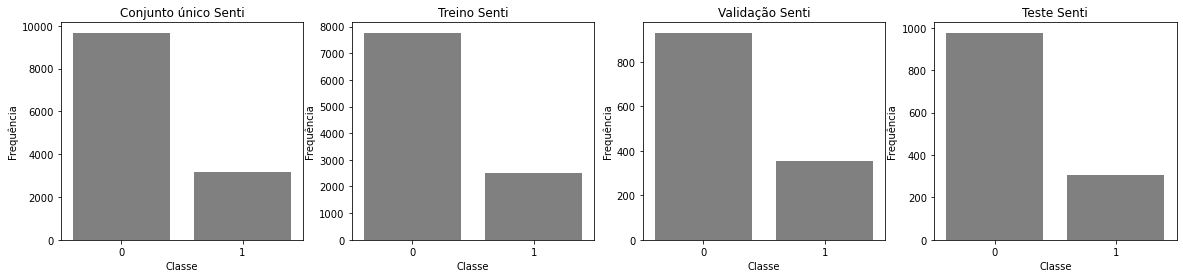

In [15]:
#plot frequência de cada classe por conjunto único ou cada partição
fig, axes = plt.subplots(1,4, sharex = True, figsize=(20,4))
for item in [0,1,2,3]:
    if item ==0:
        sns.countplot(ax=axes[item], x='label', data=senti, color='gray')
        axes[item].set_title('Conjunto único Senti')
    elif item ==1:
        sns.countplot(ax=axes[item], x='label', data=train, color="gray")
        axes[item].set_title('Treino Senti')
    elif item ==2:
        sns.countplot(ax=axes[item], x='label', data=val, color="gray")
        axes[item].set_title('Validação Senti')
    else:
        sns.countplot(ax=axes[item], x='label', data=test, color="gray")
        axes[item].set_title('Teste Senti')
    axes[item].set_xlabel('Classe')
    axes[item].set_ylabel('Frequência')
plt.savefig('Frequência_por_classes_dataset_senti.pdf')

In [16]:
%%capture
# pré-processamento dos textos # baseado em [3]

# importação das bibliotecas
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') # stop word list
import re
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud 
import string
from collections import Counter, defaultdict

def clean_text(text):
    translate_table = dict((ord(char), None) for char in string.punctuation)
    text = text.translate(translate_table)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",re.MULTILINE | re.UNICODE)
    re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")
    text = re_url.sub("URL", text)
    text = re_ip.sub("IPADDRESS", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
#    text = " ".join(stemmed_words)
#    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in stemmed_words if not w in stops and len(w) >= 3]
    text = " ".join(text)
    return text

#tokenizer 
# baseado em [2]
def tokenizer(text, flg_stemm=True, flg_lemm=False, lst_stopwords=stopwords_list):
    lst_text = text.lower().split()
    if flg_stemm == True: 
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if flg_lemm == True: 
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)  
    return text

def CountOnly(sentence): # função para contar os valores únicos
    sentence=sentence.split()
    result = Counter(sentence)
    return result

def cleanningOnceTrain(statement): # criando função para limpar do corpus aquelas palavras que ocorrem uma única vez
  statement=statement.split()
  result = [word for word in statement if word not in list_unique_train]
  result = " ".join(result)
  return result

def cleanningOnceVal(statement):  #criando função para limpar do corpus aquelas palavras que ocorrem uma única vez
#  for item in [val]:
  statement=statement.split()
  result = [word for word in statement if word not in list_unique_val]
  result = " ".join(result)
  return result
def cleanningOnceTest(statement): # criando função para limpar do corpus aquelas palavras que ocorrem uma única vez
  statement=statement.split()
  result = [word for word in statement if word not in list_unique_test]
  result = " ".join(result)
  return result
def cleanningOnce(statement): #criando função para limpar do corpus aquelas palavras que ocorrem uma única vez
  statement=statement.split()
  result = [word for word in statement if word not in list_unique]
  result = " ".join(result)
  return result

train['statement']=train['statement'].map(clean_text)
test['statement']=test['statement'].map(clean_text)
val['statement']=val['statement'].map(clean_text)

train_to_count=train.copy()
val_to_count=val.copy()
test_to_count=test.copy()

train_to_count['statement']=train_to_count['statement'].apply(CountOnly) # aplicando a função ao dataset
val_to_count['statement']=val_to_count['statement'].apply(CountOnly)
test_to_count['statement']=test_to_count['statement'].apply(CountOnly)

c_train=Counter() # calculando a soma para o dataset train
c_val=Counter() # calculando a soma para o dataset val
c_test=Counter() # calculando a soma para o dataset test

for sentence in train_to_count['statement']:
  c_train = c_train + sentence
for sentence in val_to_count['statement']:
  c_val = c_val + sentence
for sentence in test_to_count['statement']:
  c_test = c_test + sentence

list_unique_train=[] # criando lista pra selecionar os valores que aparecem uma única vez no corpus

for k,v in c_train.items():
  if v==1:
    list_unique_train.append(k)
list_unique_val=[]
for k,v in c_val.items():
  if v==1:
    list_unique_val.append(k)
list_unique_test=[]
for k,v in c_test.items():
  if v==1:
    list_unique_test.append(k)

train['statement']=train['statement'].apply(cleanningOnceTrain) #aplicando ao conjunto de dados
val['statement']=val['statement'].apply(cleanningOnceVal)
test['statement']=test['statement'].apply(cleanningOnceTest)

senti_preprocessed = pd.concat([train,val,test], axis=0, sort = False)

text_senti = senti['statement'].values
text_senti_true, text_senti_fake = senti['statement'][senti['label']==1].values, senti['statement'][senti['label']==0].values
text_senti_preprocessed = senti_preprocessed['statement'].values
text_senti_preprocessed_true, text_senti_preprocessed_fake = senti_preprocessed['statement'][senti_preprocessed['label']==1].values, senti_preprocessed['statement'][senti_preprocessed['label']==0].values

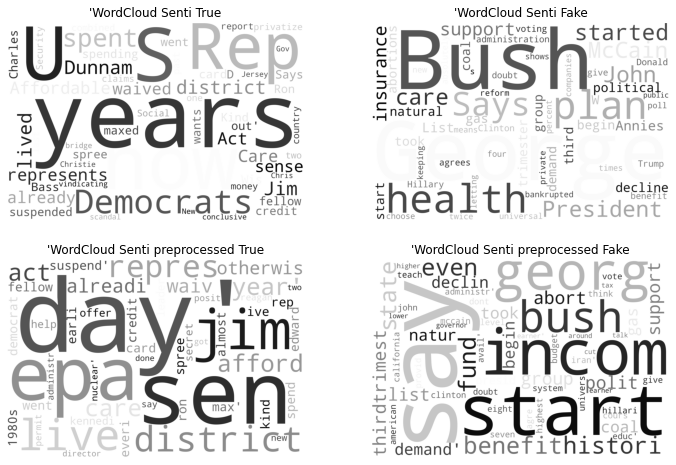

In [21]:
# figura com wordclouds senti, senti label true, senti label fake, 
# senti preprocessed, senti preprocessed label true, senti preprocessed label fake

plt.figure(figsize=(12, 8)) 
#plt.subplot(2, 3, 1) 
#wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti))
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.title("'WordCloud Senti")

#plt.subplot(2, 3, 2)
plt.subplot(2, 2, 1)
wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti_true))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("'WordCloud Senti True")

#plt.subplot(2, 3, 3)
plt.subplot(2, 2, 2)
wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti_fake))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("'WordCloud Senti Fake")

#plt.subplot(2, 3, 4) 
#wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti_preprocessed))
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.title("'WordCloud Senti preprocessed")

#plt.subplot(2, 3, 5)
plt.subplot(2, 2, 3)
wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti_preprocessed_true))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("'WordCloud Senti preprocessed True")

#plt.subplot(2, 3, 6)
plt.subplot(2, 2, 4)
wordcloud = WordCloud(width=3000, height=2000, background_color='white', colormap='gray', stopwords=STOPWORDS).generate(str(text_senti_preprocessed_fake))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("'WordCloud Senti preprocessed Fake")

# Subplots
#plt.tight_layout()  
#plt.show()
plt.savefig('WordClouds_Senti.pdf')
#plt.close()

Referência: 

[1] Upadhayay, B., & Behzadan, V. (2020, November). Sentimental liar: Extended corpus and deep learning models for fake claim classification. In 2020 IEEE International Conference on Intelligence and Security Informatics (ISI) (pp. 1-6). IEEE.

Links: 

[2] https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794. 

[3] https://github.com/Tawkat/Fake-News-Detection/blob/master/Codes/Neural_Network_based_Methods/DataPrep/Clean_Texts.py